In [1]:
import os
os.chdir('/raid/jimyeong/nohlab_diffusion')

In [2]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.utils import make_grid
%matplotlib inline
sns.set_style('darkgrid')

/home/jimyeong/.conda/envs/ddpm/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


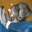

In [3]:
transform = Compose([
    ToTensor(),
    Normalize(0.5, 0.5),
])
dataset = CIFAR10('~/datasets', train=False, download=True, transform=transform)
def show_tensor_image(tensor, size_mult=1, **kwargs):
    if tensor.ndim == 4:
        tensor = make_grid(tensor, **kwargs)
    tensor = torch.clip(tensor * 0.5 + 0.5, 0, 1)
    tensor_np = tensor.permute(1, 2, 0).cpu().numpy()
    image = Image.fromarray((tensor_np * 255).astype(np.uint8))
    if size_mult != 1:
        new_size = (int(image.width * size_mult), int(image.height * size_mult))
        image = image.resize(new_size, resample=Image.NEAREST)
    return image
show_tensor_image(dataset[0][0])

In [4]:
from diffusers import FlowMatchEulerDiscreteScheduler
n_steps = 1000
shift = 1.0
scheduler = FlowMatchEulerDiscreteScheduler(num_train_timesteps=n_steps, shift=shift)
scheduler.sigmas.shape, scheduler.sigmas[0], scheduler.sigmas[-1]

(torch.Size([1000]), tensor(1.), tensor(0.0010))

/home/jimyeong/.conda/envs/ddpm/lib/python3.12/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'FlowMatchEulerDiscreteScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'FlowMatchEulerDiscreteScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


<Axes: xlabel='None', ylabel='None'>

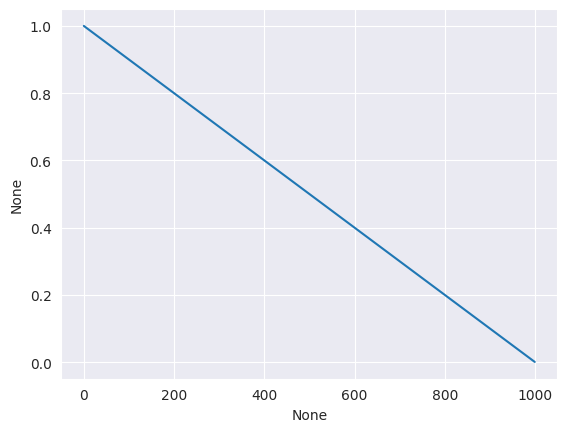

In [5]:
sns.lineplot(x=torch.arange(scheduler.num_train_timesteps), y=scheduler.sigmas)

In [6]:
from diffusion.scheduler import get_scheduler
scheduler = get_scheduler('rectified_flow', n_steps=1000)
scheduler.sigmas.shape, scheduler.sigmas[0], scheduler.sigmas[-1]

(torch.Size([1000]), tensor(0.0010), tensor(1.))

torch.Size([5, 3, 32, 32])


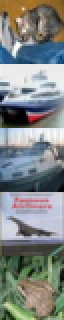

In [7]:
sample_image = torch.stack([dataset[i][0] for i in range(5)], dim=0)
eps = torch.randn_like(sample_image)
print(sample_image.shape)
show_tensor_image(sample_image, size_mult=2, nrow=1, padding=0)

In [8]:
def show_diffusion_process(sample_image, scheduler, eps):
    diffuse_total = 10
    steps = torch.linspace(0, scheduler.n_steps - 1, steps=diffuse_total+1, dtype=torch.long)[1:]
    print(steps)
    total = [sample_image]
    for step in steps:
        diffused = scheduler.diffuse(sample_image, eps=eps, t=step)
        total.append(diffused)
    total = torch.stack(total, dim=0).transpose(0, 1).reshape(-1, *sample_image.shape[1:])
    print(total.shape)
    return show_tensor_image(total, size_mult=2, nrow=diffuse_total+1, padding=0)

tensor([ 99, 199, 299, 399, 499, 599, 699, 799, 899, 999])
torch.Size([55, 3, 32, 32])


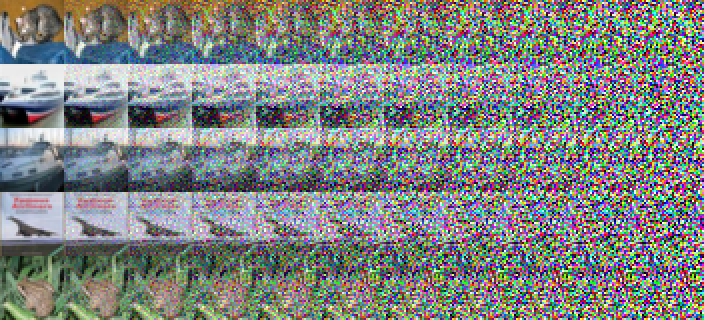

In [9]:
show_diffusion_process(sample_image, scheduler, eps)

tensor([ 99, 199, 299, 399, 499, 599, 699, 799, 899, 999])
torch.Size([55, 3, 32, 32])


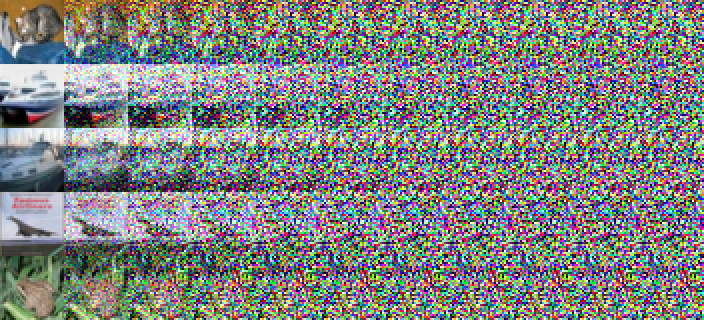

In [11]:
beta_scheduler = get_scheduler('beta', n_steps=1000)
show_diffusion_process(sample_image, beta_scheduler, eps)

tensor([ 99, 199, 299, 399, 499, 599, 699, 799, 899, 999])
torch.Size([55, 3, 32, 32])


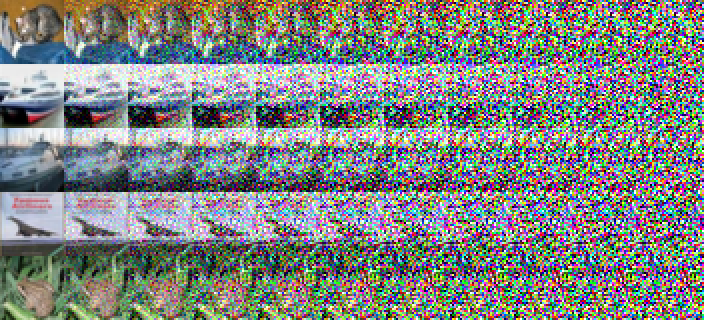

In [13]:
cosine_scheduler = get_scheduler('beta', schedule='cosine', n_steps=1000)
show_diffusion_process(sample_image, cosine_scheduler, eps)